In [1]:
import matplotlib.pyplot as plt
import numpy as np            
import pandas as pd        
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications import ResNet101
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Đường dẫn thư mục
train_path = r'.\train'
test_path = r'.\test'
val_path = r'.\val'

batch_size = 32 
img_height = 224
img_width = 224


In [2]:
# Data augmentation
image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.7,1.3],
    fill_mode='nearest'
)

test_data_gen = ImageDataGenerator(rescale=1./255)


In [3]:
# Generators
train_generator = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='rgb', 
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

validation_generator = test_data_gen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)


Found 1943 images belonging to 2 classes.
Found 611 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


In [4]:
print(train_generator.class_indices)


{'1_Normal': 0, '2_Disease': 1}


In [5]:
def create_resnet_model(num_classes=1):
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

resnet_model = create_resnet_model()

# Compile model
resnet_model.compile(optimizer=Adam(learning_rate=1e-4), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy', tf.keras.metrics.AUC()])

# Callbacks
early = EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
callbacks_list = [early, reduce_lr]

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# Train model
history = resnet_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks_list
)


171446536/171446536 [==============================] - 10s 0us/step
Class weights: {0: 1.763157894736842, 1: 0.6979166666666666}
Epoch 1/50
61/61 [==============================] - 323s 5s/step - loss: 0.7427 - accuracy: 0.5023 - auc: 0.5030 - val_loss: 0.7103 - val_accuracy: 0.2897 - val_auc: 0.5048 - lr: 1.0000e-04
Epoch 2/50
61/61 [==============================] - 133s 2s/step - loss: 0.7246 - accuracy: 0.5018 - auc: 0.5092 - val_loss: 0.8505 - val_accuracy: 0.2897 - val_auc: 0.5668 - lr: 1.0000e-04
Epoch 3/50
61/61 [==============================] - 134s 2s/step - loss: 0.7133 - accuracy: 0.5039 - auc: 0.5148 - val_loss: 0.6671 - val_accuracy: 0.7103 - val_auc: 0.5468 - lr: 1.0000e-04
Epoch 4/50
61/61 [==============================] - 137s 2s/step - loss: 0.7169 - accuracy: 0.4925 - auc: 0.4889 - val_loss: 0.6926 - val_accuracy: 0.5915 - val_auc: 0.5502 - lr: 1.0000e-04
Epoch 5/50
61/61 [==============================] - 137s 2s/step - loss: 0.7065 - accuracy: 0.5157 - auc: 0.512

In [6]:
resnet_model.save('ResNet101_model.h5')


c:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
# Evaluate model
test_loss, test_acc, test_auc = resnet_model.evaluate(test)
print('Test accuracy:', test_acc)
print('Test AUC:', test_auc)

# Predictions and metrics
y_pred_proba = resnet_model.predict(test)
y_pred = (y_pred_proba > 0.5).astype(int)
y_true = test.classes

conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

class_report = classification_report(y_true, y_pred, target_names=['Normal', 'Disease'])
print('Classification Report:')
print(class_report)

tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
recall = sensitivity
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Sensitivity: {sensitivity * 100:.2f}%')
print(f'Specificity: {specificity * 100:.2f}%')
print(f'F1-Score: {f1_score:.2f}')


20/20 [==============================] - 34s 2s/step - loss: 0.6710 - accuracy: 0.6776 - auc: 0.5013
Test accuracy: 0.6775777339935303
Test AUC: 0.5013242363929749
20/20 [==============================] - 33s 2s/step
Confusion Matrix:
[[  0 197]
 [  0 414]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       197
     Disease       0.68      1.00      0.81       414

    accuracy                           0.68       611
   macro avg       0.34      0.50      0.40       611
weighted avg       0.46      0.68      0.55       611

Sensitivity: 100.00%
Specificity: 0.00%
F1-Score: 0.81


c:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

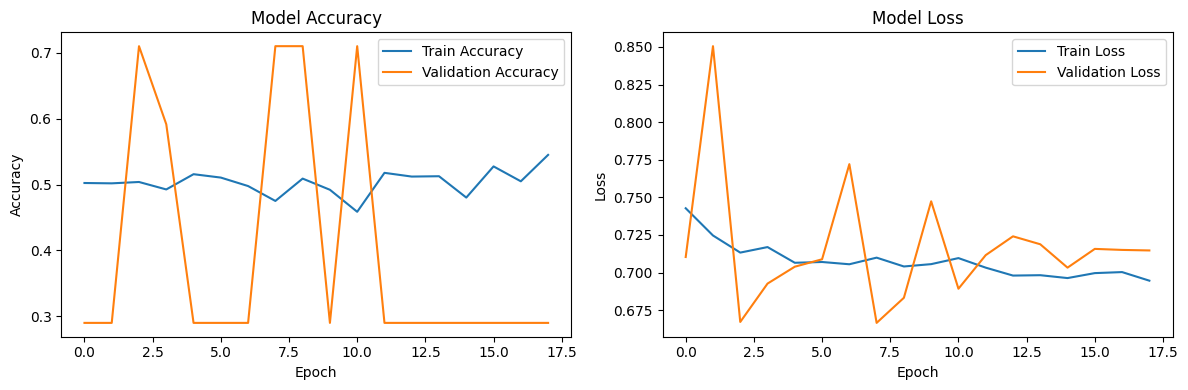

In [8]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



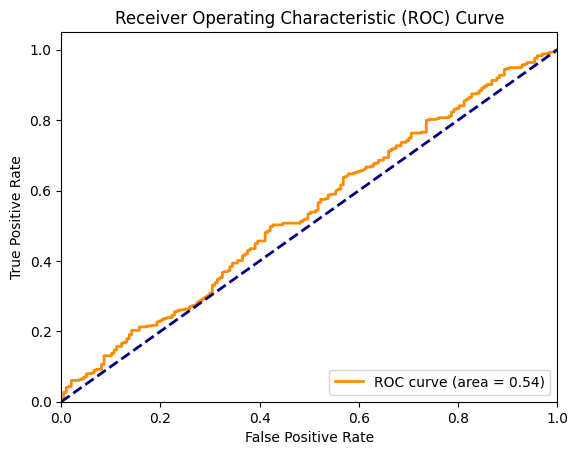

In [9]:
# Plot ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = roc_auc_score(y_true, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
